#setup

##import

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pmdarima
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import stationarity
import pmdarima as pm
from pmdarima.arima import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00


##function declaration

In [3]:
def import_data ():
  df1 = pd.read_parquet('/content/drive/MyDrive/demand_prj/data/yellow_tripdata_2023-01.parquet', engine='pyarrow')
  df2 = pd.read_parquet('/content/drive/MyDrive/demand_prj/data/yellow_tripdata_2023-02.parquet', engine='pyarrow')
  df3 = pd.read_parquet('/content/drive/MyDrive/demand_prj/data/yellow_tripdata_2023-03.parquet', engine='pyarrow')
  df4 = pd.read_parquet('/content/drive/MyDrive/demand_prj/data/yellow_tripdata_2023-04.parquet', engine='pyarrow')
  return (df1, df2, df3, df4)

In [4]:
def drop_time (df1, df2, df3, df4):
  df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime']).dt.normalize()
  df2['tpep_pickup_datetime'] = pd.to_datetime(df2['tpep_pickup_datetime']).dt.normalize()
  df3['tpep_pickup_datetime'] = pd.to_datetime(df3['tpep_pickup_datetime']).dt.normalize()
  df4['tpep_pickup_datetime'] = pd.to_datetime(df4['tpep_pickup_datetime']).dt.normalize()
  return (df1, df2, df3, df4)

In [5]:
def date_filtered (df1, df2, df3, df4):
  df1_filtered = df1.loc[((df1['tpep_pickup_datetime'] >= '2023-01-01') & (df1['tpep_pickup_datetime'] <= '2023-01-31'))]
  df2_filtered = df2.loc[((df2['tpep_pickup_datetime'] >= '2023-02-01') & (df2['tpep_pickup_datetime'] <= '2023-02-28'))]
  df3_filtered = df3.loc[((df3['tpep_pickup_datetime'] >= '2023-03-01') & (df3['tpep_pickup_datetime'] <= '2023-03-31'))]
  df4_filtered = df4.loc[((df4['tpep_pickup_datetime'] >= '2023-04-01') & (df4['tpep_pickup_datetime'] <= '2023-04-30'))]
  return (df1_filtered, df2_filtered, df3_filtered, df4_filtered)

In [6]:
def select_features (df1_filtered, df2_filtered, df3_filtered, df4_filtered):
  ndf1 = df1_filtered[['tpep_pickup_datetime','PULocationID']]
  ndf2 = df2_filtered[['tpep_pickup_datetime','PULocationID']]
  ndf3 = df3_filtered[['tpep_pickup_datetime','PULocationID']]
  ndf4 = df4_filtered[['tpep_pickup_datetime','PULocationID']]
  return (ndf1, ndf2, ndf3, ndf4)

In [7]:
def one_hot_encoding_PULocationID (ndf1, ndf2, ndf3, ndf4):
  ndf1_onh = pd.get_dummies(ndf1,columns = ['PULocationID'])
  ndf2_onh = pd.get_dummies(ndf2,columns = ['PULocationID'])
  ndf3_onh = pd.get_dummies(ndf3,columns = ['PULocationID'])
  ndf4_onh = pd.get_dummies(ndf4,columns = ['PULocationID'])
  return (ndf1_onh, ndf2_onh, ndf3_onh, ndf4_onh)

In [8]:
def groupby_day_of_month (ndf1_onh, ndf2_onh, ndf3_onh, ndf4_onh):
  daily_df1 = ndf1_onh.groupby(ndf1_onh['tpep_pickup_datetime'].dt.day)[ndf1_onh.columns[1:]].sum()
  daily_df2 = ndf2_onh.groupby(ndf2_onh['tpep_pickup_datetime'].dt.day)[ndf2_onh.columns[1:]].sum()
  daily_df3 = ndf3_onh.groupby(ndf3_onh['tpep_pickup_datetime'].dt.day)[ndf3_onh.columns[1:]].sum()
  daily_df4 = ndf4_onh.groupby(ndf4_onh['tpep_pickup_datetime'].dt.day)[ndf4_onh.columns[1:]].sum()
  return (daily_df1, daily_df2, daily_df3, daily_df4)

In [9]:
def concat_data (daily_df1, daily_df2, daily_df3, daily_df4):
  data_dayloc = pd.concat([daily_df1, daily_df2, daily_df3, daily_df4], ignore_index = True, sort = False)
  data_dayloc[data_dayloc.isna()] = 0
  return data_dayloc

In [10]:
def eval_stationary (data_dayloc):
  stationary_result = []
  col = data_dayloc.columns
  st_dic = {}
  for l in col:
    X = data_dayloc.loc[:,l].values
    stationary_result = adfuller(X)
    if stationary_result[0] < stationary_result[4].get('5%'):
      st_dic[l] = 1
    else:
      st_dic[l] = 0

  print('being stationary(1) or not(0): \n', st_dic)

In [11]:
def eval_stationary_3test (data_dayloc):
  stationary_result = []
  col = data_dayloc.columns
  st_dic = {}
  for l in col:
    diff_adf = ndiffs(data_dayloc.loc[:,l], test='adf')
    diff_kpss = ndiffs(data_dayloc.loc[:,l], test='kpss')
    diff_pp = ndiffs(data_dayloc.loc[:,l], test='pp')
    print( f'\n\n{l} \ndiff suggest by ADF: {diff_adf} \ndiff suggest by kpss: {diff_kpss} \ndiff suggest by pp: {diff_pp}' )

In [12]:
def split_data (data_dayloc, location, size_tr):
  size = int(len(data_dayloc) * size_tr)
  val_tr = data_dayloc.loc[0:size, location]
  val_te = data_dayloc.loc[size:, location]
  return (val_tr, val_te)

In [1]:
def arima_forecast (val_tr, val_te):
  history = [x for x in val_tr]
  predictions = []
  model = pm.arima.auto_arima(
                              history, start_p=1, start_q=1,
                              test='kpss', max_p=5, max_q=5,
                              seasonal=False, m=1,
                              d=None, start_P=0,
                              suppress_warnings=True, trace=True)
  for t in range(len(val_te)):
    best_arima_model_fit = pm.arima.ARIMA(order=model.get_params().get("order")).fit(history)
    output = best_arima_model_fit.predict(n_periods=1)
    yhat = output[0]
    predictions.append(int(yhat))
    obs = val_te.iloc[t]
    history.append(obs)

  val_te = val_te.reset_index()
  return (val_te.iloc[:,1], predictions,
          history, best_arima_model_fit.fittedvalues())


In [15]:
def rmse (val_te, predictions):
  rmse = sqrt(mean_squared_error(val_te, predictions))
  return rmse

In [16]:
def mape (val_te, predictions):
  mape = mean_absolute_percentage_error(val_te, predictions)
  return mape

##load data and preprocessing

In [17]:
res_import_data = import_data()

Clear hours-minutes-seconds from the 'tpep_pickup_datetime' column

In [18]:
res_drop_time = drop_time (res_import_data[0], res_import_data[1], res_import_data[2], res_import_data[3])

###Clear outlier data

In [19]:
res_date_filtered = date_filtered (res_drop_time[0], res_drop_time[1],
                                   res_drop_time[2], res_drop_time[3])

###selecting features

Extract 2 column 'tpep_pickup_datetime','PULocationID' of dataset

In [20]:
res_select_features = select_features (res_date_filtered[0], res_date_filtered[1],
                                       res_date_filtered[2], res_date_filtered[3])

In [21]:
del(res_import_data)
del(res_date_filtered);del(res_drop_time)


###OneHotEncoding

Apply OneHotEncoding to 'PULocationID'

In [22]:
res_one_hot_encoding_PULocationID = one_hot_encoding_PULocationID (res_select_features[0], res_select_features[1],
                                                                   res_select_features[2], res_select_features[3])

In [23]:
del(res_select_features)

In [24]:
res_groupby_day_of_month = groupby_day_of_month (res_one_hot_encoding_PULocationID[0], res_one_hot_encoding_PULocationID[1],
                                                 res_one_hot_encoding_PULocationID[2], res_one_hot_encoding_PULocationID[3])

In [25]:
del(res_one_hot_encoding_PULocationID)

###Concat datasets

In [26]:
data_dayloc = concat_data (res_groupby_day_of_month[0], res_groupby_day_of_month[1],
                           res_groupby_day_of_month[2], res_groupby_day_of_month[3])

In [27]:
del(res_groupby_day_of_month)

###Stationary Tests

Dickey-Fuller test was used for stationary.


In [28]:
res_eval_stationary = eval_stationary (data_dayloc)

being stationary(1) or not(0): 
 {'PULocationID_1': 1, 'PULocationID_2': 1, 'PULocationID_3': 1, 'PULocationID_4': 1, 'PULocationID_5': 1, 'PULocationID_6': 0, 'PULocationID_7': 0, 'PULocationID_8': 1, 'PULocationID_9': 1, 'PULocationID_10': 0, 'PULocationID_11': 1, 'PULocationID_12': 0, 'PULocationID_13': 0, 'PULocationID_14': 1, 'PULocationID_15': 1, 'PULocationID_16': 1, 'PULocationID_17': 0, 'PULocationID_18': 1, 'PULocationID_19': 1, 'PULocationID_20': 1, 'PULocationID_21': 0, 'PULocationID_22': 0, 'PULocationID_23': 1, 'PULocationID_24': 0, 'PULocationID_25': 0, 'PULocationID_26': 0, 'PULocationID_28': 0, 'PULocationID_29': 1, 'PULocationID_30': 1, 'PULocationID_31': 1, 'PULocationID_32': 0, 'PULocationID_33': 0, 'PULocationID_34': 1, 'PULocationID_35': 1, 'PULocationID_36': 0, 'PULocationID_37': 0, 'PULocationID_38': 1, 'PULocationID_39': 0, 'PULocationID_40': 1, 'PULocationID_41': 0, 'PULocationID_42': 0, 'PULocationID_43': 0, 'PULocationID_44': 1, 'PULocationID_45': 0, 'PULoca

In [29]:
res_eval_stationary_3test = eval_stationary_3test (data_dayloc)



PULocationID_1 
diff suggest by ADF: 0 
diff suggest by kpss: 0 
diff suggest by pp: 0


PULocationID_2 
diff suggest by ADF: 0 
diff suggest by kpss: 0 
diff suggest by pp: 0


PULocationID_3 
diff suggest by ADF: 0 
diff suggest by kpss: 0 
diff suggest by pp: 0


PULocationID_4 
diff suggest by ADF: 0 
diff suggest by kpss: 0 
diff suggest by pp: 0


PULocationID_5 
diff suggest by ADF: 0 
diff suggest by kpss: 0 
diff suggest by pp: 0


PULocationID_6 
diff suggest by ADF: 0 
diff suggest by kpss: 0 
diff suggest by pp: 0


PULocationID_7 
diff suggest by ADF: 0 
diff suggest by kpss: 1 
diff suggest by pp: 0


PULocationID_8 
diff suggest by ADF: 0 
diff suggest by kpss: 0 
diff suggest by pp: 0


PULocationID_9 
diff suggest by ADF: 0 
diff suggest by kpss: 0 
diff suggest by pp: 0


PULocationID_10 
diff suggest by ADF: 1 
diff suggest by kpss: 1 
diff suggest by pp: 0


PULocationID_11 
diff suggest by ADF: 0 
diff suggest by kpss: 1 
diff suggest by pp: 0


PULocationID_12 


#ARIMA MODEL

##online train

constant

In [30]:
col = data_dayloc.columns
l = 20  #g202
location = col[l]
size_tr = 0.9
all_loc_rmse = []
all_loc_mape = []
val_predicted = {}
val_test = {}

In [36]:
val_tr, val_te = split_data (data_dayloc, location, size_tr)
result = arima_forecast (val_tr, val_te)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1468.453, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1485.470, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1485.893, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1477.821, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1483.477, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1459.694, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1461.676, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1458.840, Time=0.32 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1435.080, Time=0.19 s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

##evaluation

In [37]:
val_rmse = rmse (result[0], result[1])
val_mape = mape (result[0], result[1])

locationID= PULocationID_211
Test RMSE: 191.874
Test mape: 0.169


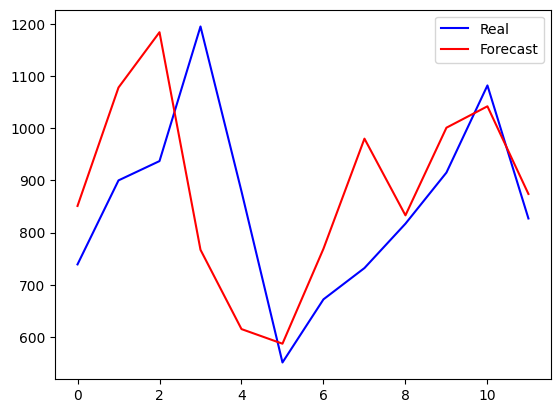

In [38]:
print('locationID= %s\nTest RMSE: %.3f\nTest mape: %.3f' % (location, val_rmse, val_mape))
plt.plot(result[0], color='blue')
plt.plot(result[1], color='red')
plt.legend(['Real','Forecast'])
plt.show()

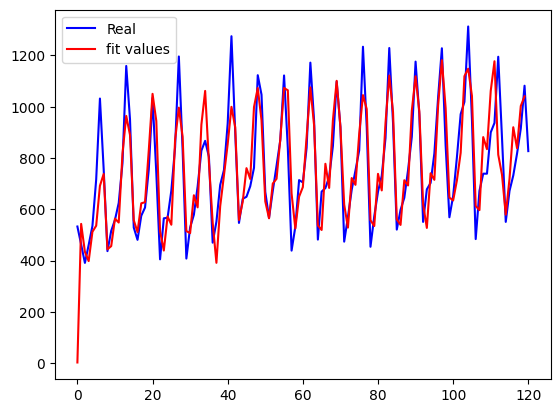

In [39]:
plt.plot(result[2], color='blue')
plt.plot(result[3], color='red')
plt.legend(['Real','fit values'])
plt.show()

calculate for each locationID


In [40]:
for loc in col:
  print('\n\nlocation: %s' %(loc))
  val_tr, val_te = split_data (data_dayloc, loc, size_tr)
  result = arima_forecast(val_tr, val_te)
  val_rmse = rmse (result[0], result[1])
  val_mape = mape (result[0], result[1])
  all_loc_rmse.append(val_rmse)
  all_loc_mape.append(val_mape)
  val_test[loc] = result[0]
  val_predicted[loc] = result[1]


val_test=pd.DataFrame(val_test)
val_predicted=pd.DataFrame(val_predicted)



location: PULocationID_1
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=735.132, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=907.149, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=755.169, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=842.590, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=736.616, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=809.921, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=740.154, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=737.463, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=723.416, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=725.980, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=722.682, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=733.436, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=722.994, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=458.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=441.749, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=456.192, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=430.450, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=427.630, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=428.708, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=425.668, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=428.477, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=426.748, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning



location: PULocationID_14
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=597.912, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=789.493, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=637.997, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=718.132, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=596.885, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=628.181, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=598.026, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=598.106, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=596.429, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=695.670, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=598.103, Time=0.28 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=670.329, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=590.939, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_24
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1122.150, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1543.978, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1120.904, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1416.342, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1124.726, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1086.718, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1110.967, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1079.249, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1073.537, Time=0.20 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1072.381, Time=0.38 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1074.357, Time=0.41 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1074.380, Time=0.45 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1074.794, Time=0.37 sec
 ARIMA(5,0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_33
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=864.975, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=863.982, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=862.980, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.018 seconds


location: PULocationID_34
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=428.007, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=495.774, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=455.998, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=472.851, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=429.292, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=429.281, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=464.353, Time=0.10 sec
 ARIMA(2,

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_36
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=770.772, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=827.205, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=769.172, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=784.405, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=770.916, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=747.276, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=752.459, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=738.351, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=734.518, Time=0.13 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=726.499, Time=0.19 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=722.576, Time=0.27 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=723.961, Time=0.42 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=726.426, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_43
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1509.049, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1506.964, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1488.798, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1507.137, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1489.177, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.854 seconds


location: PULocationID_44
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=436.224, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=422.276, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_45
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1067.809, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1069.771, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1069.730, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1065.816, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.479 seconds


location: PULocationID_46
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=208.394, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=179.521, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=206.489, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=167.004, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=163.650, Time=0.08 sec
 ARIMA(4,

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_48
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1652.071, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1654.044, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1650.072, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.359 seconds


location: PULocationID_49
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=737.665, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=703.275, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=735.666, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=699.812, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=694.624, Time=0.11 sec
 ARIMA(4,1,0)(

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_52
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=975.062, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=735.258, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=881.552, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=733.258, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=734.077, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.76 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=692.927, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=695.071, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=685.020, Time=0.23 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=685.706, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=686.004, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=686.981, Time=0.36 sec
 ARIMA(4,0,1)(0,0,0)[0] interce

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_56
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=585.326, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=778.453, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=644.703, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=719.234, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=587.103, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=587.066, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=692.210, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=622.542, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=581.811, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=581.834, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=581.829, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=583.542, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=583.635, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_66
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=842.374, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=836.057, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=840.438, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=827.709, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=824.152, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=813.891, Time=0.40 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=809.456, Time=0.50 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=800.500, Time=0.65 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=799.012, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : A

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_67
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=387.651, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=508.939, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=435.883, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=471.508, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=389.570, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=389.565, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=452.851, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=421.554, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=383.106, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=381.113, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=379.168, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=381.116, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.065 seconds


location:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning



location: PULocationID_70
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1286.416, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1337.509, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1329.287, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1285.148, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1335.519, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1284.741, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1286.214, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1284.920, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1327.309, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1282.233, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1276.009, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1275.051, Time=0.11 sec
 ARIMA(2,1,0)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_73
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=364.786, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=352.244, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=356.483, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=348.967, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=344.090, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=342.446, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=344.010, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=321.715, Time=0.29 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=320.211, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : A

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_74
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1139.212, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1129.952, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1137.222, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1127.988, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1128.963, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1125.992, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1127.954, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1126.971, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1102.112, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1100.377, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]  

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_77
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=449.707, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=508.692, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=490.094, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=447.765, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=506.729, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=449.684, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=449.416, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=448.635, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.792 seconds


location: PULocationID_78
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=549.311, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=665.068, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=549.611, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=603.669, Time=0.03 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st



location: PULocationID_80
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=929.214, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1002.889, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=932.560, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=938.934, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=927.774, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=933.133, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=926.875, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=925.140, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=927.133, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=927.793, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=887.980, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=887.035, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=906.827, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=880.448, Time=0.23 sec
 ARIMA(1,0,1)(0,0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels



location: PULocationID_81
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=512.930, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=498.689, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=510.953, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=493.676, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=491.386, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=488.315, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=476.192, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=468.017, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=463.943, Time=1.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : A

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_82
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=889.225, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=695.492, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=809.245, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=685.394, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=681.921, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=679.198, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=679.178, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=647.677, Time=0.33 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=648.243, Time=0.22 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=649.555, Time=0.51 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=649.330, Time=0.36 sec

Best model:  ARIMA(5,0,0)(0,0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning



location: PULocationID_98
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=503.752, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=529.814, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=515.740, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=519.745, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=518.269, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=516.183, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=498.821, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=496.822, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=497.144, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=498.820, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=496.973, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] interce

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_100
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1496.175, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1494.089, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1494.223, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1494.319, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1492.237, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.268 seconds


location: PULocationID_101
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=495.405, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=446.136, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=467.375, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=438.195, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=433.682, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=430.481, Time=0.13 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels



location: PULocationID_109
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=114.789, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=115.022, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=113.979, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=113.750, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=115.559, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=116.585, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=109.382, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=108.713, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=109.628, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=109.536, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.589 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_111
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3.601, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12.076, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11.849, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11.342, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4.320, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5.074, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7.018, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13.795, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3.643, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-0.080, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7.871, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8.086, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1.187, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=9.507, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AI

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_112
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=912.713, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1008.807, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=910.914, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=944.970, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=912.845, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=913.431, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=879.391, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=886.155, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=863.917, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=862.118, Time=0.20 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=853.992, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=844.951, Time=0.42 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=843.906, Time=0.56 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=853.254, Time=0.39 sec
 ARIMA(5,0,2)(0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_113
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1506.537, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1508.503, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1499.150, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1504.597, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1499.370, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.820 seconds


location: PULocationID_114
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1675.079, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1901.365, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1691.612, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_115
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=133.465, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=131.825, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=131.598, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=131.514, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=133.489, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=135.453, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=126.765, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=125.464, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=126.874, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=128.367, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.037 seconds


location: PULocationID_116
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=886.709, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1255.762, Time=0.02 se

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st



location: PULocationID_118
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=204.751, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=201.417, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=201.836, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=203.128, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=188.873, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=187.340, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=188.775, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=190.188, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.781 seconds


location: PULocationID_119
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=554.047, Time=0.01 sec
 ARIMA(1,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_124
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=509.558, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=572.422, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=548.093, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=507.558, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=570.423, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=509.558, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=511.069, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=506.591, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=508.575, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=508.571, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=546.102, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=510.167, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.777 seconds


location: PULocationID_125
Performing stepwise search to minimize aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning



location: PULocationID_127
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=539.170, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=595.498, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=576.623, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=537.382, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=593.509, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=539.117, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=540.133, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=535.613, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=537.450, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=537.406, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=574.639, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=538.381, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.823 seconds


location: PULocationID_128
Performing stepwise search to minimize aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning



location: PULocationID_140
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1700.427, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1995.032, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1704.338, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1877.156, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1701.190, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1793.283, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1703.509, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1655.534, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1655.301, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1698.642, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1651.584, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1652.823, Time=0.19 sec
 ARIMA(0,0,3)(

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_142
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1666.397, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1667.090, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1664.496, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.316 seconds


location: PULocationID_143
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1436.358, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1852.998, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1438.341, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels



location: PULocationID_145
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1012.203, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=971.748, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1010.204, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=962.740, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=962.911, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=960.783, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=969.765, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=960.969, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=947.114, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=947.218, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_156
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=141.714, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=141.741, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=139.720, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=139.971, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=141.713, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=143.695, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=131.547, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=130.390, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=131.402, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=133.308, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.510 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_157
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=684.949, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=816.669, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=719.709, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=764.263, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=742.651, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=716.218, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=676.205, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=674.330, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=676.471, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=675.559, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=675.236, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] interc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning



location: PULocationID_162
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1740.830, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1754.661, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1742.632, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1739.381, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1752.755, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1736.937, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1734.887, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1737.410, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1712.469, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1738.850, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1608.228, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning



location: PULocationID_163
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1656.347, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1655.388, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1654.683, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1654.491, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.483 seconds


location: PULocationID_164
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1573.520, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1571.851, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1573.622, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1573.546, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1569.906, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.386 seconds


location: PULocationID_165
Performing stepwis

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_166
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1298.536, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1299.287, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1298.503, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1296.705, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.304 seconds


location: PULocationID_167
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=578.943, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=562.192, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=576.944, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=560.680, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=552.574, Time=0.07 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_168
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=674.908, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=896.421, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=731.329, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=828.318, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=676.904, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=676.904, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=797.832, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=702.961, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=669.129, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=669.093, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=667.506, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=669.017, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.302 seconds


location

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p



location: PULocationID_171
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=480.586, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=423.803, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=453.074, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=399.077, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=393.072, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=390.461, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=388.141, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=367.978, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=365.980, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=364.088, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=362.184, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] interc

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_179
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=710.091, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=681.750, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=708.157, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=677.941, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=675.912, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=669.768, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=664.021, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=662.655, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=664.607, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=660.688, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]           

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_185
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=471.569, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=568.340, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=509.434, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=537.644, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=472.856, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=472.908, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=521.240, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=496.355, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=466.909, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=464.968, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=463.615, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=464.924, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.102 seconds


location

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_187
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=43.469, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.469, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=41.469, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=41.469, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=35.884, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.579, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=37.549, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.531, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.755 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_188
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=646.428, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=718.583, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=676.155, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=716.591, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=647.931, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=646.601, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=668.366, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=646.248, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=645.530, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=646.441, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=674.197, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning



location: PULocationID_190
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=419.948, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=489.182, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=457.284, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=418.467, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=487.198, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=419.886, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=418.457, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=419.883, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=419.815, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=455.293, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.014 seconds


location: PULocationID_191
Performing stepwise search to minimize aic
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels



location: PULocationID_196
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=572.528, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=741.571, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=604.358, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=677.730, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=641.267, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=600.566, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=560.885, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=558.905, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=563.823, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=560.829, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=559.821, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] interc

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_198
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=652.705, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=568.365, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=609.649, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=566.020, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=565.347, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=561.923, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=562.738, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=544.770, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=542.778, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=541.714, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_200
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=570.866, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=510.187, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=538.511, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=500.546, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=501.299, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=464.336, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=462.777, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=461.218, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=462.734, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=464.721, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.101 seconds


location: PULoca

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_203
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=679.120, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=581.240, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=622.857, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=574.581, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=564.271, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=565.357, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=533.646, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=531.654, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=532.210, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=532.481, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_205
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=689.129, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=688.508, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=687.139, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.453 seconds


location: PULocationID_206
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=82.820, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=148.050, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=105.540, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=82.454, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=146.050, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=83.037, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=86.158, Time=0.37 sec
 ARIMA(0,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels



location: PULocationID_212
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=393.405, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=449.438, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=422.298, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=391.480, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=447.441, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=393.407, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=389.743, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=391.707, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=391.708, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=420.298, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.082 seconds


location: PULocationID_213
Performing stepwise search to minimize aic
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_214
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=282.931, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=231.931, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=248.684, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=231.873, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=231.475, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=232.776, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=196.064, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=197.961, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=187.144, Time=0.13 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=187.634, Time=0.19 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_217
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=459.682, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=609.725, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=495.520, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=548.718, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=458.385, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=484.382, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=460.380, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=457.231, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=458.319, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=458.965, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=459.038, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=460.272, Time=0.18 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=459.413, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=452.192, Time=0.37 sec
 ARIMA(1,0,2)(0,0,

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_222
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=532.689, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=683.220, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=582.192, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=632.677, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=534.526, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=534.472, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=612.624, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=570.284, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=527.842, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=526.152, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=524.576, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=526.232, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.119 seconds


location

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_230
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1646.687, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1647.856, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1646.707, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1644.856, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.338 seconds


location: PULocationID_231
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1506.728, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1507.240, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1506.489, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1504.812, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.325 seconds


location: PULocationID_232
Performing stepwise sea

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_234
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1651.173, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1653.166, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1653.165, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1649.287, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.617 seconds


location: PULocationID_235
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=543.229, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=728.455, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=595.702, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=661.585, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=639.951, Time=0.12 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_236
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1790.465, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2149.385, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1800.631, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1790.830, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1796.693, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1760.564, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1798.180, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : A

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_239
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1573.312, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1573.322, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1575.075, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1574.690, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1571.395, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.426 seconds


location: PULocationID_240
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=274.853, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=271.527, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=272.501, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=271.944, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=253.475, Time=0.06 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_241
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=492.742, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=479.317, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=490.770, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=469.659, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=463.901, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=450.668, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=448.332, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=448.004, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=446.521, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=445.211, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=446.715, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] interc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_242
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=654.410, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=759.725, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=676.656, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=708.819, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=649.685, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=676.937, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=646.014, Time=0.49 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=674.431, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=645.025, Time=0.61 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=674.369, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=638.455, Time=0.54 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=670.333, Time=0.19 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=1.00 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 ARIMA(5,0,1)(0,0,0)[0] in

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_244
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=930.298, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=926.640, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=928.298, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=920.143, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=916.814, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=913.555, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=891.843, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=873.602, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=857.343, Time=0.68 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=854.036, Time=0.70 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_245
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=77.344, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=79.551, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=78.964, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=78.743, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=79.303, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=79.313, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=80.319, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=80.901, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=76.137, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=77.831, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=77.866, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=80.067, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=79.954, Time=0.12 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: Conve



location: PULocationID_246
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1586.788, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1583.956, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1580.599, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1584.797, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1578.638, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1562.569, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1581.969, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1564.142, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1564.239, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1566.055, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1580.505, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_247
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=725.010, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=696.851, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=723.022, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=678.628, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=677.712, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=674.477, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=657.906, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=655.959, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=672.500, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=654.486, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0]           

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_248
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=457.084, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=556.667, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=483.743, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=512.628, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=454.542, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=483.070, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=452.042, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=478.553, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=452.751, Time=0.45 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=456.934, Time=0.60 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=454.585, Time=0.65 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=471.972, Time=0.11 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=455.750, Time=0.42 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=447.536, Time=0.19 sec
 ARIMA(2,0,1)(0,0,

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_251
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=207.378, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=206.335, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=206.399, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=208.288, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=198.710, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=197.198, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=198.638, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=199.672, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.911 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_252
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=390.810, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=341.922, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=366.008, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=328.969, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=329.495, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=304.000, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=302.559, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=302.018, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=302.776, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=304.366, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.263 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_253
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=209.942, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=207.104, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=207.302, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=209.023, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=188.931, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=186.932, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=188.930, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=190.388, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.607 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_254
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=591.537, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=587.566, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=589.581, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=588.852, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=585.637, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=586.917, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=556.712, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=565.709, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=555.752, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=541.271, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=576.714, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0]       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc



location: PULocationID_257
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=420.411, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=545.940, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=476.187, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=513.000, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=422.132, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=422.129, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=495.471, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=455.671, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=422.973, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=415.553, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=413.554, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=411.873, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=413.558, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.028 seconds


loca

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_263
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1571.129, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1984.171, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1578.688, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1570.484, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1577.552, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1533.392, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1510.205, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : A

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: PULocationID_105
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-196.028, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-200.028, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-198.028, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-198.028, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-199.033, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.141 seconds


location: PULocationID_176
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-44.922, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-48.922, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-46.922, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-46.922, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-50.997, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-49.157, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-49.172, Time=0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op



location: PULocationID_84
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=89.839, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.536, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.839, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35.115, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=34.600, Time=0.20 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=29.583, Time=0.32 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=25.309, Time=0.42 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=7.434, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=6.021, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=11.845, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

In [41]:
print(f'The rmse of all location= {sqrt(sum((x**2 for x in all_loc_rmse)))}\n',
      f'The mape of all location= {sqrt(sum((x**2 for x in all_loc_mape)))}')

The rmse of all location= 2841.4479436841116
 The mape of all location= 1.424163249197636e+16


plots

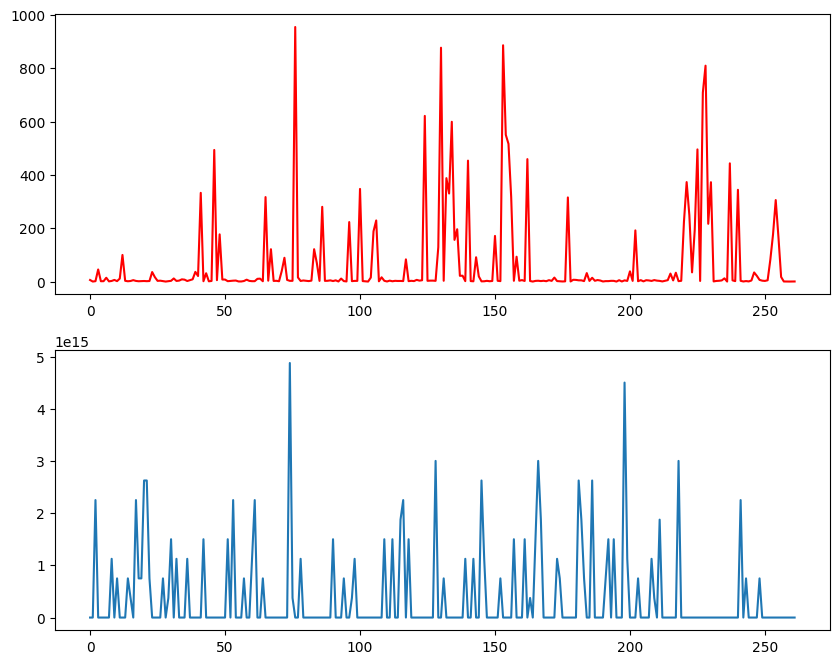

In [42]:
plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(all_loc_rmse, color = 'red')
plt.subplot(2,1,2)
plt.plot(all_loc_mape)

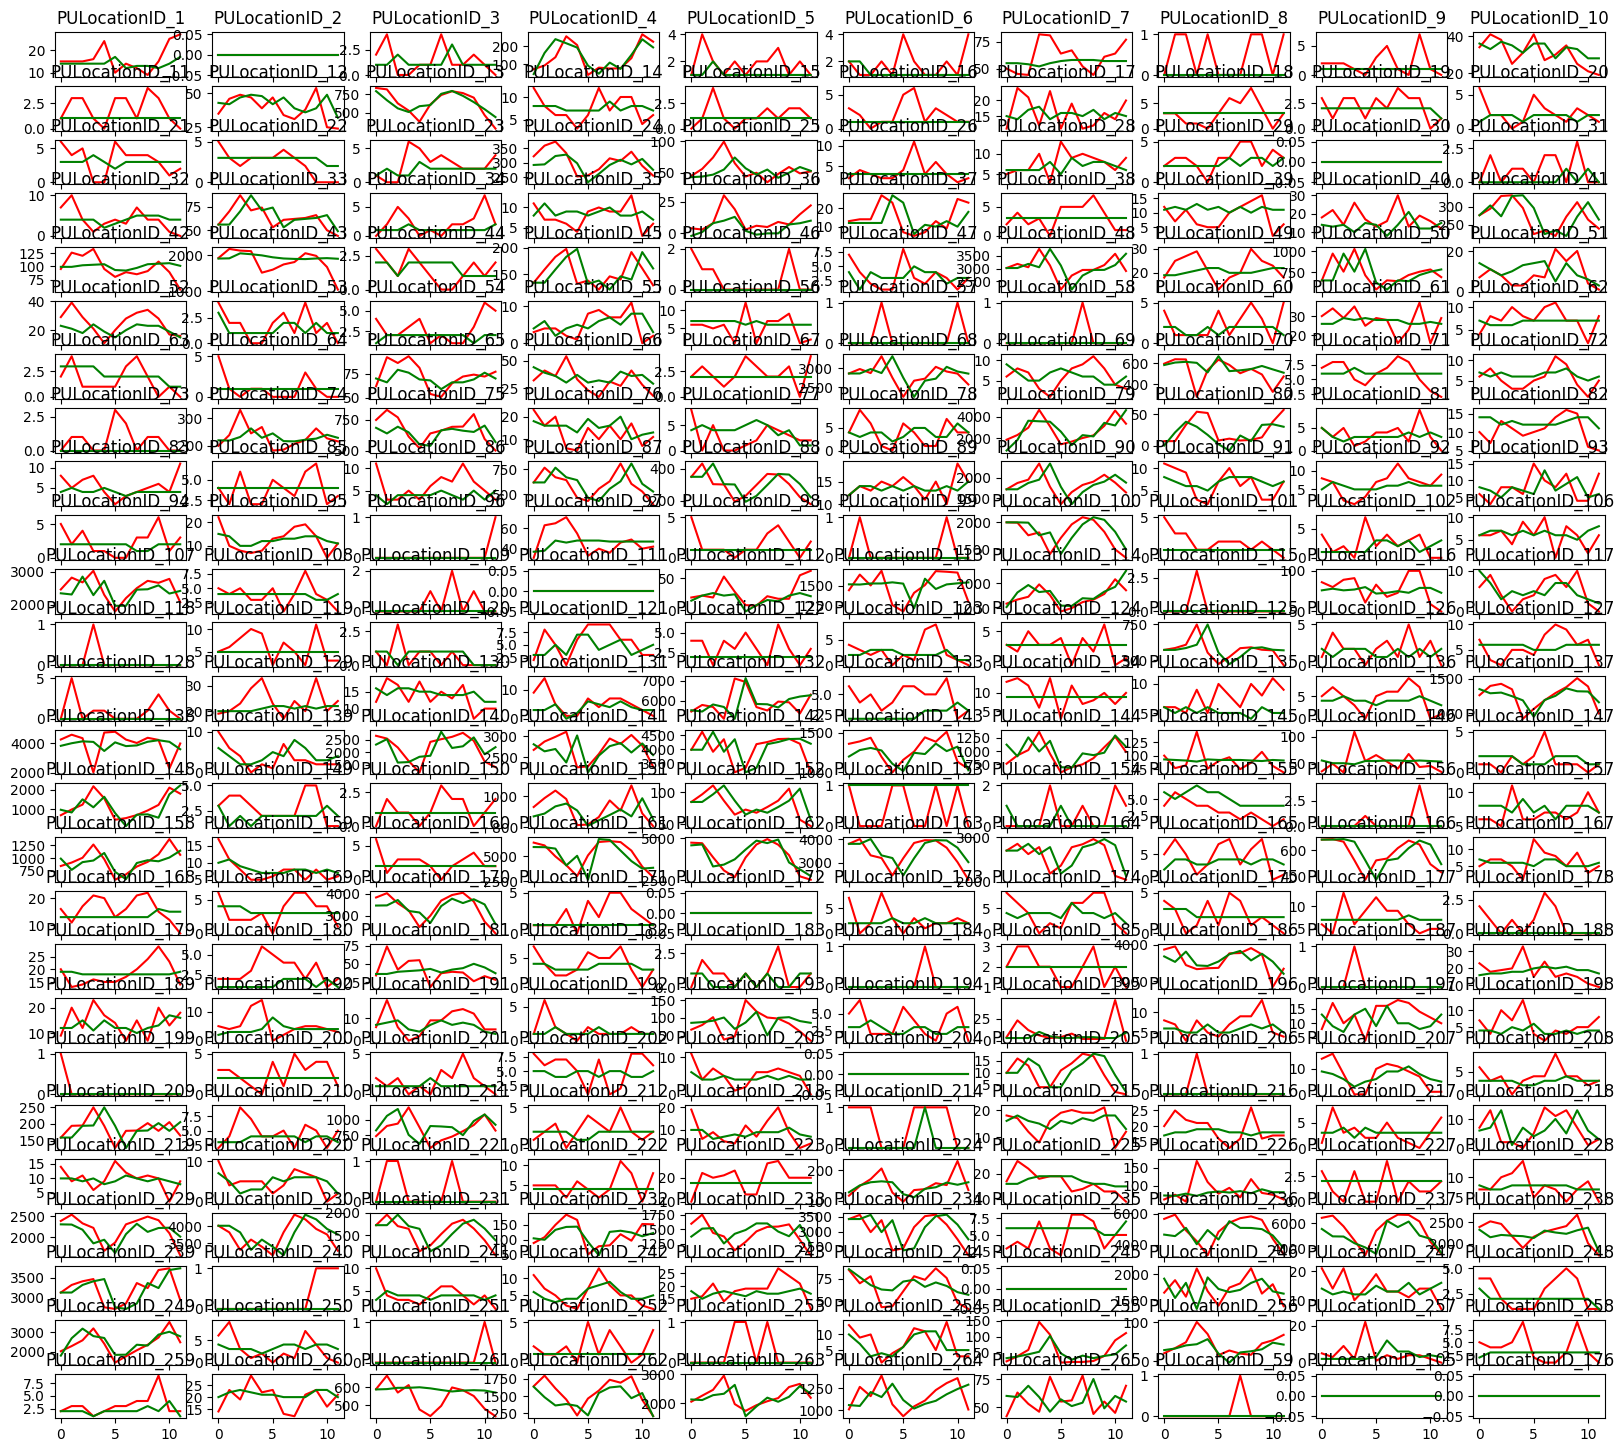

In [39]:
num_fig = 260
plt.figure(figsize = (20,18))
for i in range(num_fig):
  plt.subplot(26, 10, i+1)
  plt.plot(val_test.loc[:,col[i]], color='red')
  plt.plot(val_predicted.loc[:,col[i]], color='green')
  plt.title('%s'%col[i])

In [1]:
num_fig = 260
plt.figure(figsize = (20,18))
for i in range(num_fig):
  plt.subplot(26,10,i+1)
  plt.plot(data_dayloc.loc[60:,col[i]], color = 'red')
  plt.title('%s'%col[i])

NameError: ignored

In [40]:
sqrt()